# Using various classifiers on the red wine dataset

On this notebook we attempt to test different classifiers on the popular [red wine dataset](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?datasetId=4458&sortBy=voteCount).

## Columns description

1. **fixed acidity**: most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
2. **volatile acidity**: the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
3. **citric acid**: found in small quantities, citric acid can add 'freshness' and flavor to wines
4. **residual sugar**: the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter
5. **chlorides**: the amount of salt in the wine
6. **free sulfur dioxide**: the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents
7. **total sulfur dioxide**: amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2
8. **density**: the density of water is close to that of water depending on the percent alcohol and sugar content
9. **ph**: describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4
10. **sulphates**: a wine additive which can contribute to sulfur dioxide gas (S02) levels, which acts as an antimicrobial
11. **alcohol sulfur dioxide**: the percent alcohol content of the wine
12. **quality**: output variable (based on sensory data, score between 3 and 8) 

### Imports and directories to save results

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, zscore

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(42)

save = True
sns.set_palette("muted")

if save:
    os.makedirs("figures/", exist_ok = True)
    os.makedirs("tables/", exist_ok = True)

### The dataset

In [3]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
rows, columns = df.shape
print(f"There are {rows} rows and {columns} columns")

There are 1599 rows and 12 columns


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


There are no missing values or categorical features. Every feature is float and *quality* is int

In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


From the discrepancy between *min* and *max* values we can see that these dataset has a lot of outliers

### Data analysis

In [7]:
quality_counts = df.groupby("quality").quality.sum()
quality_counts

quality
3      30
4     212
5    3405
6    3828
7    1393
8     144
Name: quality, dtype: int64

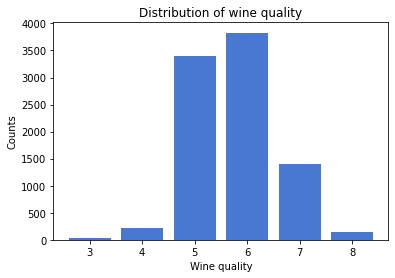

In [8]:
plt.bar(x = quality_counts.index, height=quality_counts.values)
plt.xlabel("Wine quality")
plt.ylabel("Counts")
plt.title("Distribution of wine quality")
plt.show()

From this bar plot we can see that this dataset is unbalanced with quality 5 and 6 having a lot more examples than the others.<br>
This is a problem that we will deal with later on

Now, for each feature, we are going to present:
1. histogram with the density function plotted against the normal density function
2. bar plot of how each feature influences the quality of the wine
3. finally, a box-plot to verify that there are a lot of outliers

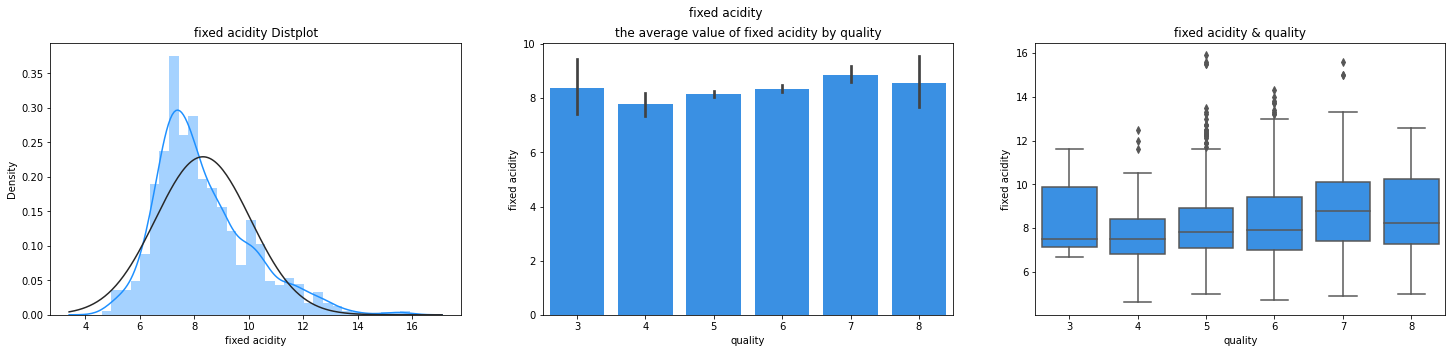

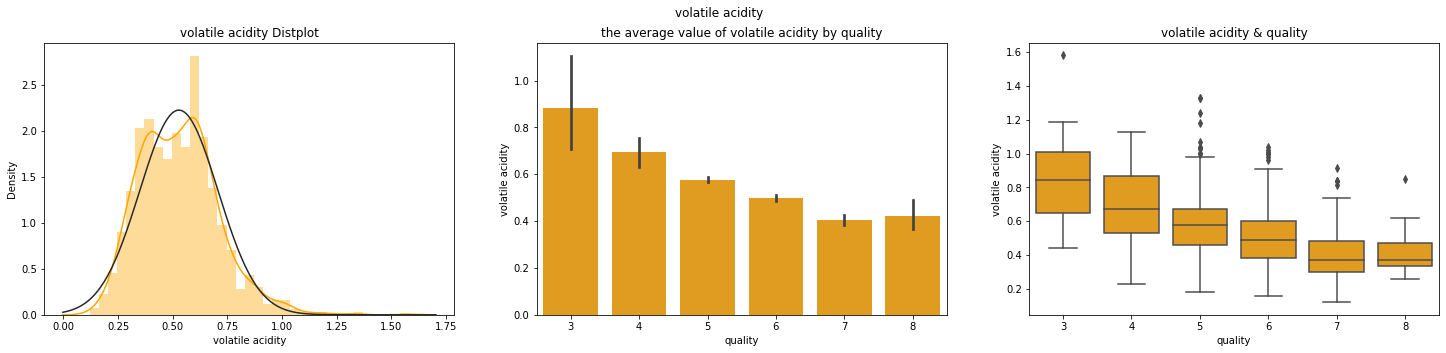

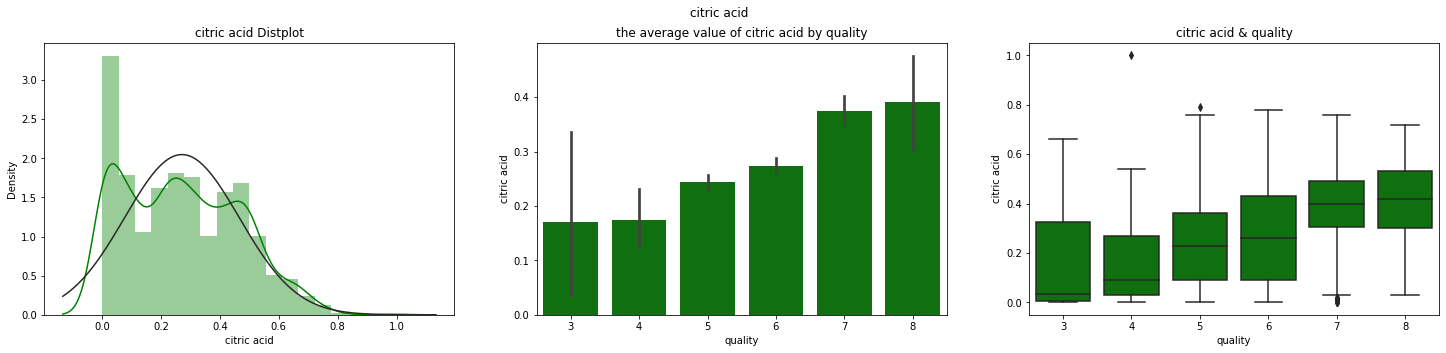

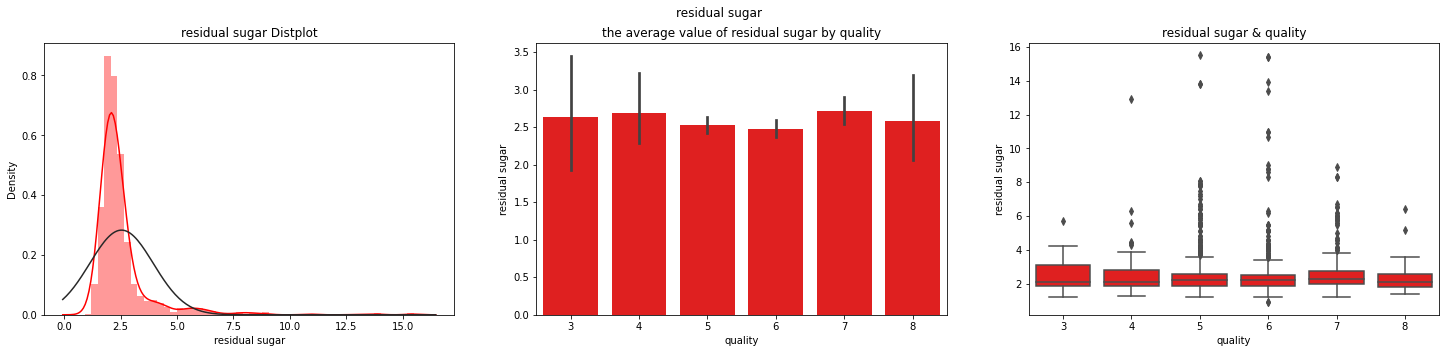

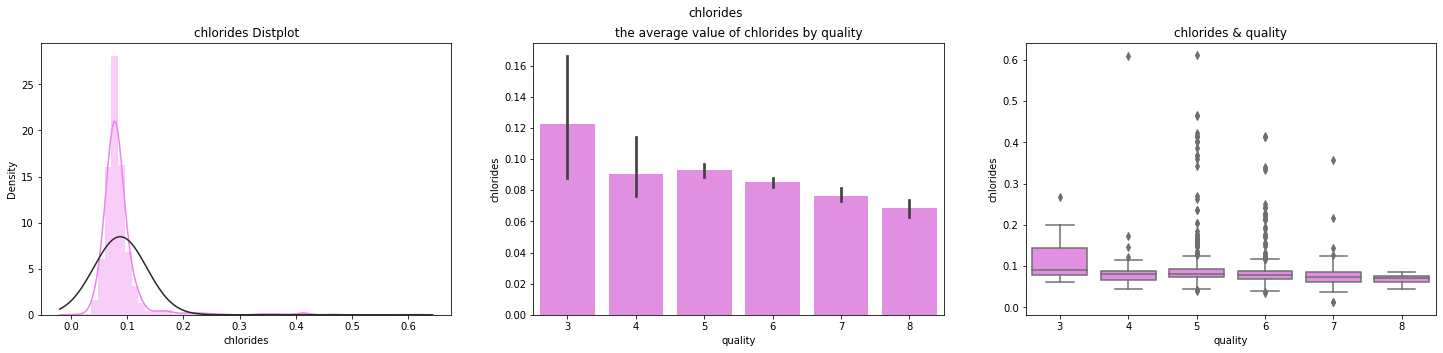

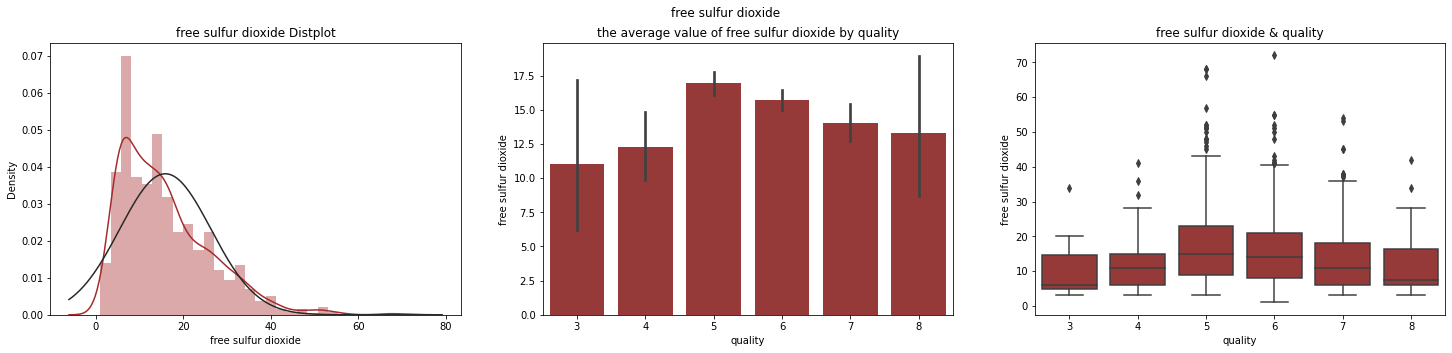

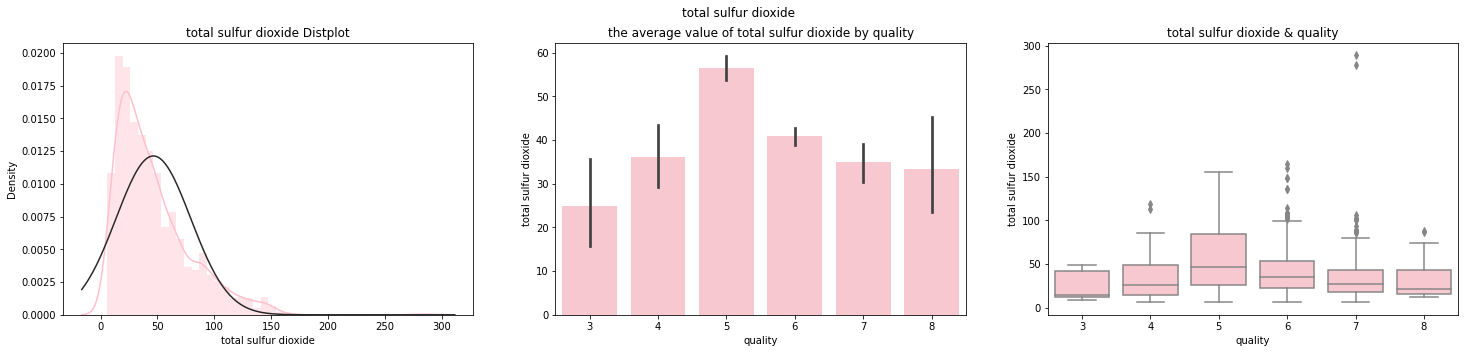

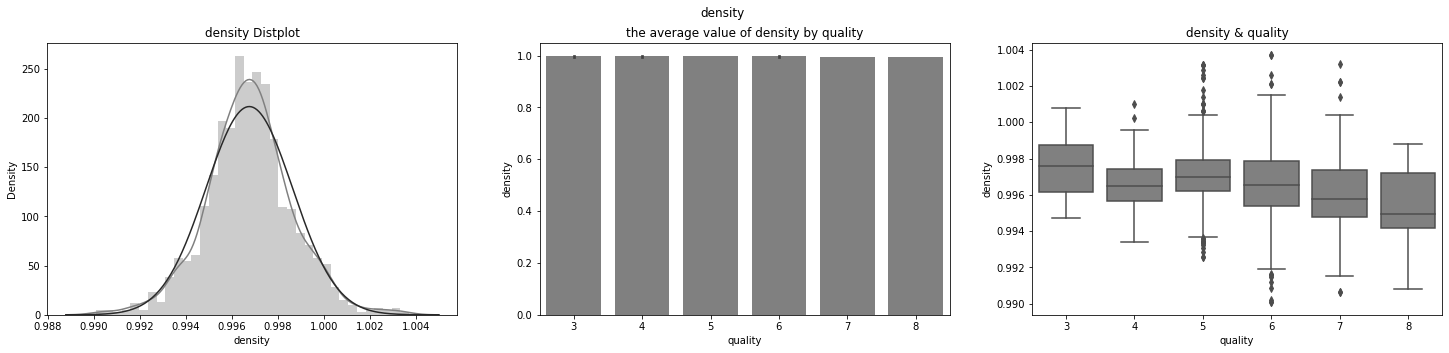

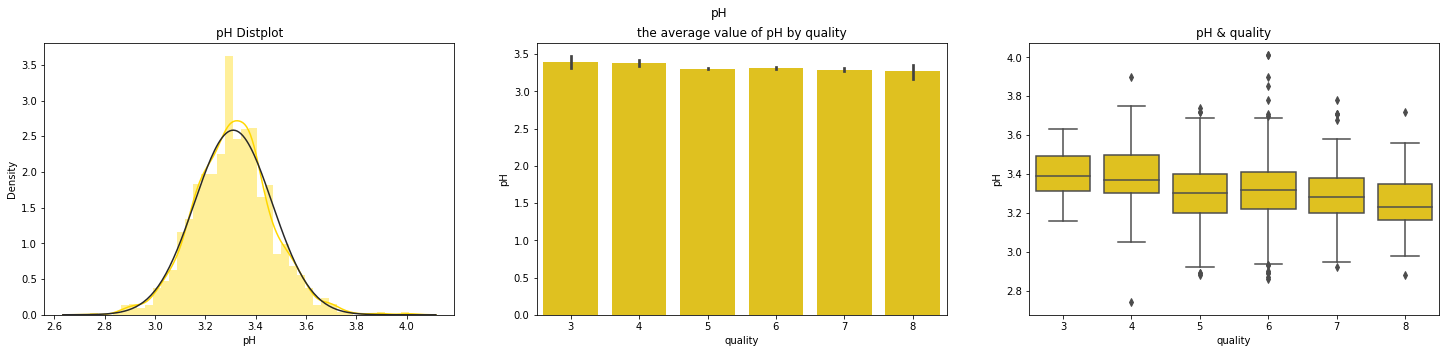

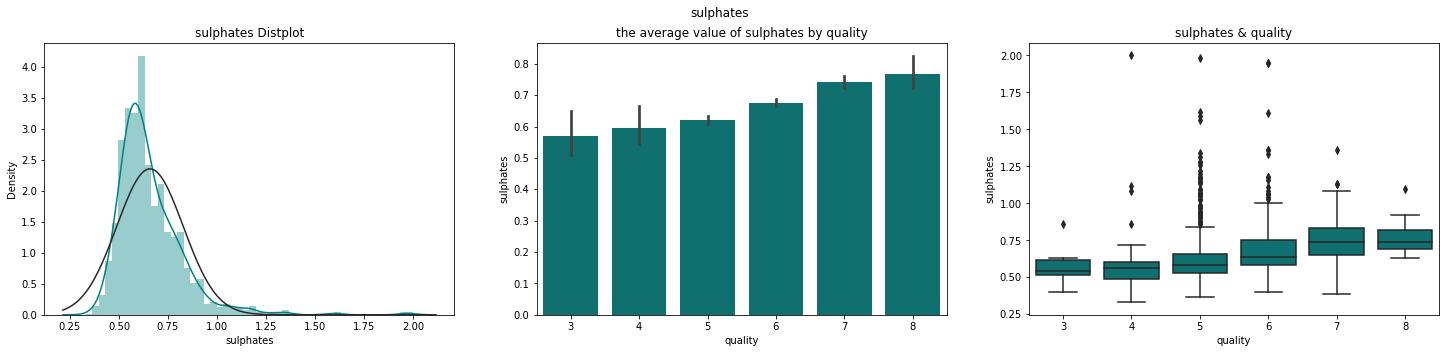

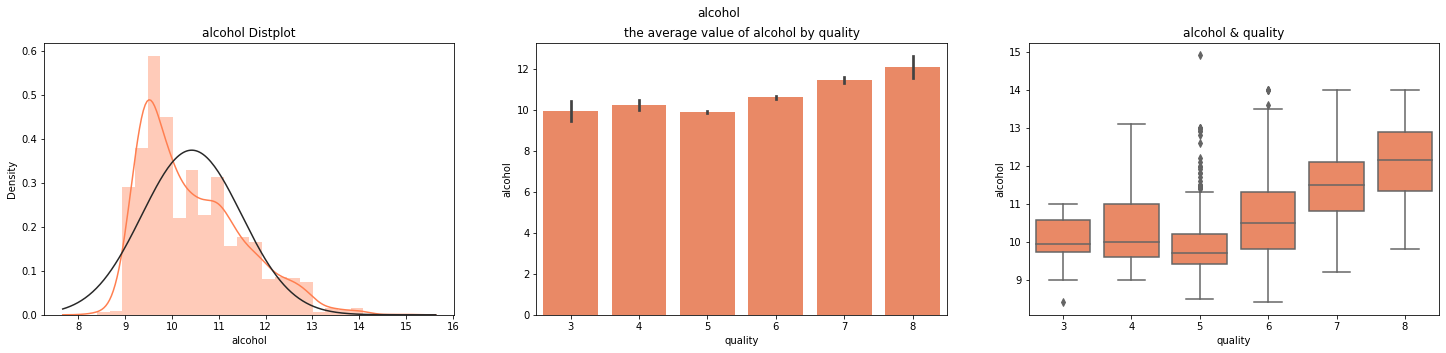

In [9]:
colors = ["dodgerblue", "orange", "green", "red", "violet", "brown", "pink", "grey", "gold", "teal", "coral"]

for column, color in zip(df.columns[:-1], colors):
    plt.figure(figsize=[25, 5])

    plt.subplot(1, 3, 1)
    sns.distplot(df[column], fit=norm, color=color)
    plt.title(f"{column} Distplot")
    plt.subplot(1, 3, 2)
    sns.barplot(x = df["quality"], y = df[column], color=color)
    plt.title(f"the average value of {column} by quality")
    plt.subplot(1, 3, 3)
    sns.boxplot(df['quality'], df[column], color=color)
    plt.title(f"{column} & quality")
    plt.suptitle(column)
    
plt.show()

Some conclusions:

1. **fixed acidity**: does not seem to affect the quality as much sense the bars don't appear to have any pattern
2. **volatile acidity**: from the average values of volatile acidity by quality, we can say that the decrease in volatile acidity seems to affect the quality positively
3. **citric acid**: the increase in citric acid seems to affect the quality positively
4. **residual sugar**: does not seem to affect the quality as much sense the bars don't appear to have any pattern
5. **chlorides**: the decrease in chlorides seems to affect the quality positively
6. **free sulfur dioxide**: Examining the average values of free sulfur dioxide by quality we cant really see that they have the free sulfur dioxide has a regular effect on the quality
7. **total sulfur dioxide**: Examining the average values of total sulfur dioxide by quality we cant really see if they have a regular effect on the quality
8. **density**: Given on how similar the average values of density by quality are we can say that density does not have much effect on the quality. Very close to a normal distribution
9. **ph**: We can see that the slight decrease on ph levels has a positive effect on quality. Also, very close to a normal distribution
10. **sulphates**: The higher the value of sulphates the more positive the quality is
11. **alcohol sulfur dioxide**: The increase on alcohol sulfur dioxide has a positive effect on quality

Overall, almost every column has a lot of outliers expect **citric acid**

Next, we are going to delete the outliers. <br>
In order to detect the outliers we are going to use the **Interquartile range rule** ($1.5 \times IQR$)

### Training and Testing Classifiers

First we are going to aggregate the 6 classes (possible values of quality) into only 2: good wine = 1 or bad wine = 0 <br>
The goal is to transform this problem into binary classification

In [10]:
df["quality"].unique()

array([5, 6, 7, 4, 8, 3])

In [11]:
df.loc[df["quality"].isin([3, 4, 5]), "quality"] = 0
df.loc[df["quality"].isin([6, 7, 8]), "quality"] = 1

In [12]:
df["quality"].unique()

array([0, 1])

In [13]:
quality_counts = df.groupby("quality").quality.count()
quality_counts

quality
0    744
1    855
Name: quality, dtype: int64

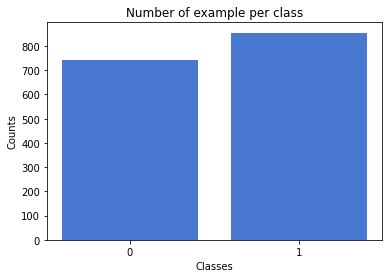

In [14]:
plt.bar(x = quality_counts.index, height=quality_counts.values)
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.title("Number of example per class")
plt.xticks([0, 1])
plt.show()

As we can see the number of examples per class are much closer <br>
Now let's split the training and test data being the quality of the wine the target variable

In [15]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [17]:
print(f"""
X_train: {X_train.shape}
y_train: {y_train.shape}
X_test: {X_test.shape}
y_test: {y_test.shape}
""")


X_train: (1279, 11)
y_train: (1279,)
X_test: (320, 11)
y_test: (320,)



Scaling the data

In [18]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Models

The classifiers we are going to use are:
1. Logistic Regression (LR)
2. Decision Tree Classifier (DTC)
3. Random Forest Classifier (RFC)
4. Support Vector Classifier (SVC)
5. K Neighbors Classifier (KNC)
6. Gaussian NB (GNB)

We are going to use sklearn's **GridSearchCV** to exhaustively search for the best parameters to tune our models

In [19]:
models_best_results = []
models_results = []
cv = 5
models_best_parameters = {}

Logistic Regression

In [20]:
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [21]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])
df_report

,precision,recall,f1-score,support
0,0.690789,0.744681,0.716724,141.000000
1,0.785714,0.737430,0.760807,179.000000
accuracy,0.740625,0.740625,0.740625,0.740625
macro avg,0.738252,0.741056,0.738765,320.000000
weighted avg,0.743888,0.740625,0.741383,320.000000


In [22]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,105,36
1,47,132


In [23]:
gscv = GridSearchCV(estimator=lr, param_grid={"C": [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]}, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .............................C=0.1;, score=0.715 total time=   0.0s
[CV 2/5] END .............................C=0.1;, score=0.727 total time=   0.0s
[CV 3/5] END .............................C=0.1;, score=0.723 total time=   0.0s
[CV 4/5] END .............................C=0.1;, score=0.742 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=0.808 total time=   0.0s
[CV 1/5] END .............................C=0.8;, score=0.715 total time=   0.0s
[CV 2/5] END .............................C=0.8;, score=0.719 total time=   0.0s
[CV 3/5] END .............................C=0.8;, score=0.723 total time=   0.0s
[CV 4/5] END .............................C=0.8;, score=0.750 total time=   0.0s
[CV 5/5] END .............................C=0.8;, score=0.816 total time=   0.0s
[CV 1/5] END .............................C=0.9;, score=0.715 total time=   0.0s
[CV 2/5] END .............................C=0.9;,

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]},
             scoring='accuracy', verbose=3)

In [24]:
models_best_parameters["lr"] = gscv.best_params_
gscv.best_params_

{'C': 0.8}

In [25]:
lr = LogisticRegression(C = gscv.best_params_["C"], random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [26]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv(f"tables/lr_report_cv_{cv}.csv")
df_report

,precision,recall,f1-score,support
0,0.690789,0.744681,0.716724,141.000000
1,0.785714,0.737430,0.760807,179.000000
accuracy,0.740625,0.740625,0.740625,0.740625
macro avg,0.738252,0.741056,0.738765,320.000000
weighted avg,0.743888,0.740625,0.741383,320.000000


In [27]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
if save:
    cm.to_csv(f"tables/lr_cm_cv_{cv}.csv")
cm

,0,1
0,105,36
1,47,132


In [28]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])

Decision Tree Classifier

In [29]:
dtc = DecisionTreeClassifier(random_state = 42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

In [30]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])
df_report

,precision,recall,f1-score,support
0,0.691781,0.716312,0.703833,141.000000
1,0.770115,0.748603,0.759207,179.000000
accuracy,0.734375,0.734375,0.734375,0.734375
macro avg,0.730948,0.732458,0.731520,320.000000
weighted avg,0.735599,0.734375,0.734808,320.000000


In [31]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,101,40
1,45,134


In [32]:
params = {
    "criterion" : ["gini", "entropy"],
    "splitter" : ["best", "random"],
    "max_depth" : np.arange(1, 11)
}

In [33]:
gscv = GridSearchCV(estimator=dtc, param_grid = params, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END criterion=gini, max_depth=1, splitter=best;, score=0.633 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, splitter=best;, score=0.668 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, splitter=best;, score=0.727 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, splitter=best;, score=0.676 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, splitter=best;, score=0.749 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, splitter=random;, score=0.629 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, splitter=random;, score=0.664 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, splitter=random;, score=0.719 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, splitter=random;, score=0.668 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, splitter=random;, score=0.757 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=3)

In [34]:
models_best_parameters["dtc"] = gscv.best_params_
gscv.best_params_

{'criterion': 'entropy', 'max_depth': 9, 'splitter': 'random'}

In [35]:
dtc = DecisionTreeClassifier(criterion=gscv.best_params_["criterion"], max_depth=gscv.best_params_["max_depth"], splitter=gscv.best_params_["splitter"], random_state = 42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

In [36]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv(f"tables/dtc_report_cv_{cv}.csv")
df_report

,precision,recall,f1-score,support
0,0.642857,0.702128,0.671186,141.000000
1,0.746988,0.692737,0.718841,179.000000
accuracy,0.696875,0.696875,0.696875,0.696875
macro avg,0.694923,0.697433,0.695014,320.000000
weighted avg,0.701105,0.696875,0.697843,320.000000


In [37]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
if save:
    cm.to_csv(f"tables/dtc_cm_cv_{cv}.csv")
cm

,0,1
0,99,42
1,55,124


In [38]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])

Random Forest Classifier

In [39]:
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [40]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])
df_report

,precision,recall,f1-score,support
0,0.757143,0.751773,0.754448,141.000000
1,0.805556,0.810056,0.807799,179.000000
accuracy,0.784375,0.784375,0.784375,0.784375
macro avg,0.781349,0.780914,0.781124,320.000000
weighted avg,0.784224,0.784375,0.784292,320.000000


In [41]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,106,35
1,34,145


In [42]:
params = {
    "n_estimators" : np.arange(50, 550, 50),
    "criterion" : ["gini", "entropy"],
    "max_depth" : np.arange(1, 11),
}

In [43]:
gscv = GridSearchCV(estimator=rfc, param_grid = params, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END criterion=gini, max_depth=1, n_estimators=50;, score=0.707 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=1, n_estimators=50;, score=0.719 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=1, n_estimators=50;, score=0.719 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=1, n_estimators=50;, score=0.727 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=1, n_estimators=50;, score=0.788 total time=   0.3s
[CV 1/5] END criterion=gini, max_depth=1, n_estimators=100;, score=0.715 total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=1, n_estimators=100;, score=0.703 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=1, n_estimators=100;, score=0.727 total time=   0.4s
[CV 4/5] END criterion=gini, max_depth=1, n_estimators=100;, score=0.738 total time=   0.4s
[CV 5/5] END criterion=gini, max_depth=1, n_estimators=100;, score=0.804 total time=   0.4s
[CV 1/5] END criterio

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
             scoring='accuracy', verbose=3)

In [44]:
models_best_parameters["rfc"] = gscv.best_params_
gscv.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200}

In [45]:
rfc = RandomForestClassifier(n_estimators=gscv.best_params_["n_estimators"], criterion=gscv.best_params_["criterion"], max_depth=gscv.best_params_["max_depth"], random_state = 42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [46]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv(f"tables/rfc_report_cv_{cv}.csv")
df_report

,precision,recall,f1-score,support
0,0.760274,0.787234,0.773519,141.000000
1,0.827586,0.804469,0.815864,179.000000
accuracy,0.796875,0.796875,0.796875,0.796875
macro avg,0.793930,0.795852,0.794692,320.000000
weighted avg,0.797927,0.796875,0.797206,320.000000


In [47]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
if save:
    cm.to_csv(f"tables/rfc_cm_cv_{cv}.csv")
cm

,0,1
0,111,30
1,35,144


In [48]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])

Support Vector Classifier

In [49]:
svc = SVC(random_state = 42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [50]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])
df_report

,precision,recall,f1-score,support
0,0.726667,0.773050,0.749141,141.000000
1,0.811765,0.770950,0.790831,179.000000
accuracy,0.771875,0.771875,0.771875,0.771875
macro avg,0.769216,0.772000,0.769986,320.000000
weighted avg,0.774268,0.771875,0.772461,320.000000


In [51]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,109,32
1,41,138


In [52]:
params = {
    'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
    'kernel':['linear', 'rbf'],
    'gamma' :[0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]
}

In [53]:
gscv = GridSearchCV(estimator=svc, param_grid = params, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.699 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.727 total time=   0.0s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.723 total time=   0.0s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.746 total time=   0.0s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.719 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.715 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.719 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.746 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.1s
[CV 1/5] END ...C=0.1, gamma=0.8, kernel=linear;, score=0.699 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.8, kernel=linea

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'gamma': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=3)

In [54]:
models_best_parameters["svc"] = gscv.best_params_
gscv.best_params_

{'C': 1.4, 'gamma': 0.8, 'kernel': 'rbf'}

In [55]:
svc = SVC(C = gscv.best_params_["C"], kernel = gscv.best_params_["kernel"], gamma = gscv.best_params_["gamma"], random_state = 42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [56]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv(f"tables/scv_report_cv_{cv}.csv")
df_report

,precision,recall,f1-score,support
0,0.792000,0.702128,0.744361,141.0000
1,0.784615,0.854749,0.818182,179.0000
accuracy,0.787500,0.787500,0.787500,0.7875
macro avg,0.788308,0.778438,0.781271,320.0000
weighted avg,0.787869,0.787500,0.785654,320.0000


In [57]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
if save:
    cm.to_csv(f"tables/svc_cm_cv_{cv}.csv")
cm

,0,1
0,99,42
1,26,153


In [58]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])

K Neighbours Classifier

In [59]:
knc = KNeighborsClassifier()

In [60]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)

In [61]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])
df_report

,precision,recall,f1-score,support
0,0.685039,0.617021,0.649254,141.00000
1,0.720207,0.776536,0.747312,179.00000
accuracy,0.706250,0.706250,0.706250,0.70625
macro avg,0.702623,0.696779,0.698283,320.00000
weighted avg,0.704711,0.706250,0.704105,320.00000


In [62]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,87,54
1,40,139


In [63]:
params = {
    "n_neighbors" : np.arange(1, 11),
    "algorithm" : ["auto", "ball_tree", "kd_tree", "brute"]
}

In [64]:
gscv = GridSearchCV(estimator=knc, param_grid = params, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END .....algorithm=auto, n_neighbors=1;, score=0.719 total time=   0.0s
[CV 2/5] END .....algorithm=auto, n_neighbors=1;, score=0.719 total time=   0.0s
[CV 3/5] END .....algorithm=auto, n_neighbors=1;, score=0.750 total time=   0.0s
[CV 4/5] END .....algorithm=auto, n_neighbors=1;, score=0.789 total time=   0.0s
[CV 5/5] END .....algorithm=auto, n_neighbors=1;, score=0.753 total time=   0.0s
[CV 1/5] END .....algorithm=auto, n_neighbors=2;, score=0.695 total time=   0.0s
[CV 2/5] END .....algorithm=auto, n_neighbors=2;, score=0.695 total time=   0.0s
[CV 3/5] END .....algorithm=auto, n_neighbors=2;, score=0.695 total time=   0.0s
[CV 4/5] END .....algorithm=auto, n_neighbors=2;, score=0.719 total time=   0.0s
[CV 5/5] END .....algorithm=auto, n_neighbors=2;, score=0.686 total time=   0.0s
[CV 1/5] END .....algorithm=auto, n_neighbors=3;, score=0.727 total time=   0.0s
[CV 2/5] END .....algorithm=auto, n_neighbors=3

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='accuracy', verbose=3)

In [65]:
models_best_parameters["knc"] = gscv.best_params_
gscv.best_params_

{'algorithm': 'auto', 'n_neighbors': 1}

In [66]:
knc = KNeighborsClassifier(n_neighbors = gscv.best_params_["n_neighbors"], algorithm = gscv.best_params_["algorithm"])
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)

In [67]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv(f"tables/knc_report_cv_{cv}.csv")
df_report

,precision,recall,f1-score,support
0,0.738462,0.680851,0.708487,141.000000
1,0.763158,0.810056,0.785908,179.000000
accuracy,0.753125,0.753125,0.753125,0.753125
macro avg,0.750810,0.745453,0.747197,320.000000
weighted avg,0.752276,0.753125,0.751794,320.000000


In [68]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
if save:
    cm.to_csv(f"tables/knc_cm_cv_{cv}.csv")
cm

,0,1
0,96,45
1,34,145


In [69]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])

GaussianNB

In [70]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [71]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])
df_report

,precision,recall,f1-score,support
0,0.702899,0.687943,0.695341,141.000000
1,0.758242,0.770950,0.764543,179.000000
accuracy,0.734375,0.734375,0.734375,0.734375
macro avg,0.730570,0.729446,0.729942,320.000000
weighted avg,0.733856,0.734375,0.734051,320.000000


In [72]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,97,44
1,41,138


In [73]:
params = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [74]:
gscv = GridSearchCV(estimator=gnb, param_grid = params, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................var_smoothing=1.0;, score=0.727 total time=   0.0s
[CV 2/5] END .................var_smoothing=1.0;, score=0.707 total time=   0.0s
[CV 3/5] END .................var_smoothing=1.0;, score=0.734 total time=   0.0s
[CV 4/5] END .................var_smoothing=1.0;, score=0.715 total time=   0.0s
[CV 5/5] END .................var_smoothing=1.0;, score=0.773 total time=   0.0s
[CV 1/5] END ..var_smoothing=0.8111308307896871;, score=0.719 total time=   0.0s
[CV 2/5] END ..var_smoothing=0.8111308307896871;, score=0.699 total time=   0.0s
[CV 3/5] END ..var_smoothing=0.8111308307896871;, score=0.734 total time=   0.0s
[CV 4/5] END ..var_smoothing=0.8111308307896871;, score=0.707 total time=   0.0s
[CV 5/5] END ..var_smoothing=0.8111308307896871;, score=0.773 total time=   0.0s
[CV 1/5] END ...var_smoothing=0.657933224657568;, score=0.719 total time=   0.0s
[CV 2/5] END ...var_smoothing=0.65793322465756

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=3)

In [75]:
models_best_parameters["gnb"] = gscv.best_params_
gscv.best_params_

{'var_smoothing': 1.0}

In [76]:
gnb = GaussianNB(var_smoothing = gscv.best_params_["var_smoothing"])
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [77]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv(f"tables/gnc_report_cv_{cv}.csv")
df_report

,precision,recall,f1-score,support
0,0.716418,0.680851,0.698182,141.000000
1,0.758065,0.787709,0.772603,179.000000
accuracy,0.740625,0.740625,0.740625,0.740625
macro avg,0.737241,0.734280,0.735392,320.000000
weighted avg,0.739714,0.740625,0.739811,320.000000


In [78]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
if save:
    cm.to_csv(f"tables/gnb_cm_cv_{cv}.csv")
cm

,0,1
0,96,45
1,38,141


In [79]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])

Final results

In [80]:
models_best_parameters

{'dtc': {'criterion': 'entropy', 'max_depth': 9, 'splitter': 'random'},
 'gnb': {'var_smoothing': 1.0},
 'knc': {'algorithm': 'auto', 'n_neighbors': 1},
 'lr': {'C': 0.8},
 'rfc': {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200},
 'svc': {'C': 1.4, 'gamma': 0.8, 'kernel': 'rbf'}}

In [81]:
df_results = pd.DataFrame(models_results, columns = ["precision", "recall", "f1-score", "accuracy"], index = ["LR", "DTC", "RFC", "SVC", "KNC", "GNB"])
df_results = df_results.round(3)
df_results = df_results * 100
if save:
  df_results.to_csv(f"tables/all_models_results_cv_{cv}.csv")
df_results

,precision,recall,f1-score,accuracy
LR,69.1,74.5,71.7,74.1
DTC,69.2,71.6,70.4,73.4
RFC,75.7,75.2,75.4,78.4
SVC,72.7,77.3,74.9,77.2
KNC,68.5,61.7,64.9,70.6
GNB,70.3,68.8,69.5,73.4


In [82]:
df_best_results = pd.DataFrame(models_best_results, columns = ["precision", "recall", "f1-score", "accuracy"], index = ["LR", "DTC", "RFC", "SVC", "KNC", "GNB"])
df_best_results = df_best_results.round(3)
df_best_results = df_best_results * 100
if save:
  df_best_results.to_csv(f"tables/all_models_best_results_cv_{cv}.csv")
df_best_results

,precision,recall,f1-score,accuracy
LR,69.1,74.5,71.7,74.1
DTC,64.3,70.2,67.1,69.7
RFC,76.0,78.7,77.4,79.7
SVC,79.2,70.2,74.4,78.8
KNC,73.8,68.1,70.8,75.3
GNB,71.6,68.1,69.8,74.1


In [83]:
results_comparison = [[result[0], best_result[0], result[1], best_result[1], result[2], best_result[2], result[3], best_result[3]] for result, best_result in zip(models_results, models_best_results)]

In [84]:
df_results_comparison = pd.DataFrame(results_comparison, columns = ["precision", "precision_CV", "recall", "recall_CV", "f1-score", "f1-score_CV", "accuracy", "accuracy_CV"], index = ["LR", "DTC", "RFC", "SVC", "KNC", "GNB"])
df_results_comparison = df_results_comparison.round(3)
df_results_comparison = df_results_comparison * 100
if save:
  df_results_comparison.to_csv(f"tables/results_comparison.csv")
df_results_comparison

,precision,precision_CV,recall,recall_CV,f1-score,f1-score_CV,accuracy,accuracy_CV
LR,69.1,69.1,74.5,74.5,71.7,71.7,74.1,74.1
DTC,69.2,64.3,71.6,70.2,70.4,67.1,73.4,69.7
RFC,75.7,76.0,75.2,78.7,75.4,77.4,78.4,79.7
SVC,72.7,79.2,77.3,70.2,74.9,74.4,77.2,78.8
KNC,68.5,73.8,61.7,68.1,64.9,70.8,70.6,75.3
GNB,70.3,71.6,68.8,68.1,69.5,69.8,73.4,74.1
